In [1]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd

ox.config(log_console=True, use_cache=True)
weight_by_length = False

ox.__version__

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


'0.10'

In [2]:
# define the study sites as label : query
places = {'Atlanta'       : 'Atlanta, GA, USA',
          'Boston'        : 'Boston, MA, USA',
          #'Buffalo'       : 'Buffalo, NY, USA',
          'Charlotte'     : 'Charlotte, NC, USA',
          #'Chicago'       : 'Chicago, IL, USA',
          'Cleveland'     : 'Cleveland, OH, USA',
          #'Dallas'        : 'Dallas, TX, USA',
          'Houston'       : 'Houston, TX, USA',
          #'Denver'        : 'Denver, CO, USA',
          #'Detroit'       : 'Detroit, MI, USA',
          #'Las Vegas'     : 'Las Vegas, NV, USA',
          #'Los Angeles'   : {'city':'Los Angeles', 'state':'CA', 'country':'USA'},
          'Manhattan'     : 'Manhattan, NYC, NY, USA',
          'Miami'         : 'Miami, FL, USA',
          #'Minneapolis'   : 'Minneapolis, MN, USA',
          'Orlando'       : 'Orlando, FL, USA',
          'Philadelphia'  : 'Philadelphia, PA, USA',
          'Providence'    : 'Providence, Rhode Island, USA'} 
          #'Phoenix'       : 'Phoenix, AZ, USA',
          #'Portland'      : 'Portland, OR, USA',
          #'Sacramento'    : 'Sacramento, CA, USA',
          #'San Francisco' : {'city':'San Francisco', 'state':'CA', 'country':'USA'},
          #'Seattle'       : 'Seattle, WA, USA',
          #'St Louis'      : 'St. Louis, MO, USA',
          #'Tampa'         : 'Tampa, FL, USA',
          #'Washington'    : 'Washington, DC, USA'}

In [3]:
# verify OSMnx geocodes each query to what you expect
gdf = ox.gdf_from_places(places.values())
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,-84.289560,33.886823,33.647808,-84.551068,"(POLYGON ((-84.551068 33.720793, -84.550962 33...","Atlanta, Fulton County, Georgia, USA"
1,-70.804488,42.396977,42.227911,-71.191260,"POLYGON ((-71.19126 42.2828375, -71.1910708000...","Boston, Suffolk County, Massachusetts, USA"
2,-80.670104,35.393133,35.013174,-81.009554,"POLYGON ((-81.00955399999999 35.151438, -81.00...","Charlotte, Mecklenburg County, North Carolina,..."
3,-81.532744,41.604436,41.390628,-81.879094,"POLYGON ((-81.8790937 41.396415, -81.879059100...","Cleveland, Cuyahoga County, Ohio, USA"
4,-95.012052,30.110351,29.537070,-95.909742,"(POLYGON ((-95.2682133 29.9545607, -95.2683068...","Houston, Harris County, Texas, USA"
5,-73.906159,40.880449,40.683941,-74.047222,"(POLYGON ((-74.0472219 40.6908633, -74.0472201...","Manhattan, New York County, New York, United S..."
6,-80.139157,25.855783,25.709052,-80.319760,"POLYGON ((-80.31976 25.7624927, -80.319682 25....","Miami, Miami-Dade County, Florida, USA"
7,-81.227586,28.614283,28.348063,-81.507538,"(POLYGON ((-81.4237634 28.5070299, -81.4228179...","Orlando, Orange County, Florida, USA"
8,-74.955831,40.137959,39.867005,-75.280298,"POLYGON ((-75.28029770000001 39.9750019, -75.2...","Philadelphia, Philadelphia County, Pennsylvani..."
9,-71.373614,41.861571,41.772414,-71.472667,"POLYGON ((-71.472667 41.837111, -71.472645 41....","Providence, Providence County, Rhode Island, U..."


In [4]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [5]:
bearings = {}
for place in sorted(places.keys()):
    
    # get the graph
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

In [6]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [7]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Century Gothic', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Century Gothic', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [8]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':60, 'fontweight':'normal', 'y':1.07}
fig.suptitle('City Street Network Orientation', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig('images/street-orientations.png', dpi=120, bbox_inches='tight')
plt.close()

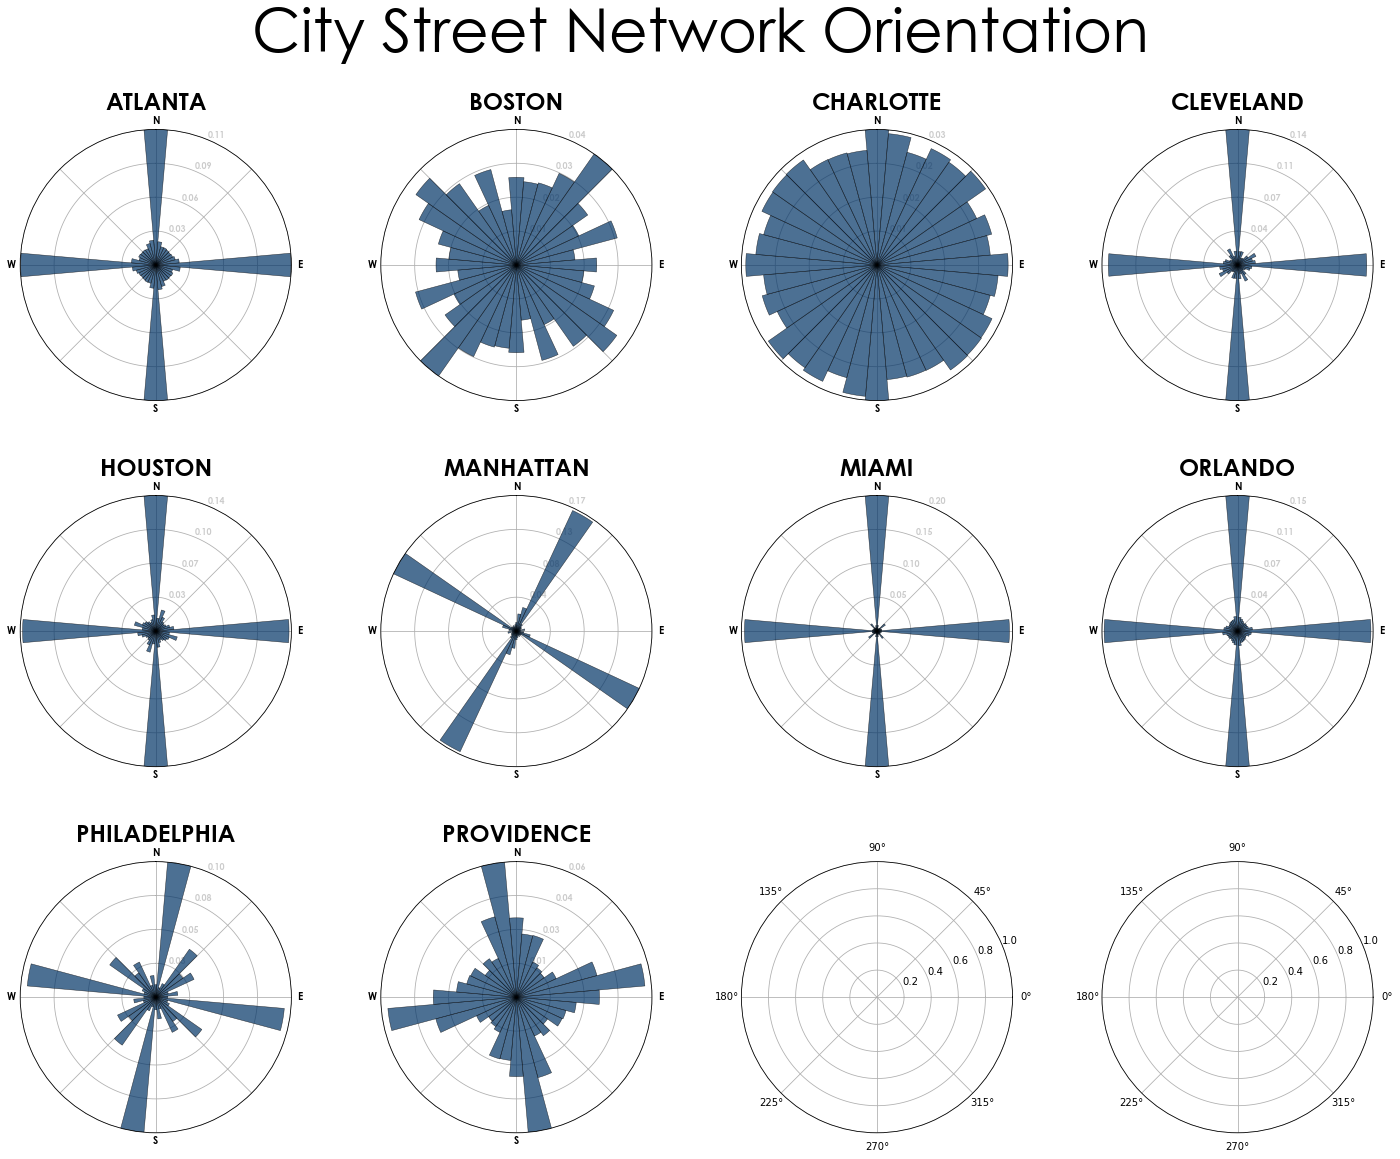

In [9]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':60, 'fontweight':'normal', 'y':1.07}
fig.suptitle('City Street Network Orientation', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
#fig.savefig('images/street-orientations.png', dpi=120, bbox_inches='tight')
#plt.close()